<a href="https://colab.research.google.com/github/kakafune2323/MTS_basicML/blob/main/HW_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание к семинару "введение в нейронные сети"

# 1. Затухание градиентов

В домашней работе чуть больше внимания уделим градиентам.     
Для начала посмотрим на графики функций активации и их производных

Еще мы сегодня нарисуем нашу сеть, для этого поставим torchview

In [1]:
!pip install torchview -q

In [2]:
import numpy as np
import plotly.express as px
import pandas as pd

In [3]:
def sigmoid(g):
  return 1 / (1 + np.exp(-g))

def der_sigmoid(g):
  a = sigmoid(g)
  return np.multiply(a, 1 - a)

In [4]:
df = pd.DataFrame()
df['x'] = np.linspace(-5, 5, 10_000)
df['сигмоида'] = sigmoid(df['x'])
df['ее_производная'] = der_sigmoid(df['x'])

fig = px.line(df, x='x', y=df.columns[1::])
fig.update_layout(
                  xaxis_title=""
                  , yaxis_title=""
                  , title="Сигмоида и ее производная"
                  , height=600
                  , width=1200
                  , font_family="Arial"
                  , font_color="black"
                  , font_size = 16
                  , title_font_family="Times New Roman"
                  , title_font_size = 18
                  , title_font_color="black"
                  , separators=", .*"
)
fig.show()

In [5]:
def tanh(x):
    return np.tanh(x)

def der_tanh(x):
  a = np.tanh(x)
  return 1 - np.multiply(a, a)

In [6]:
df = pd.DataFrame()
df['x'] = np.linspace(-5, 5, 10_000)
df['tanh'] = tanh(df['x'])
df['производная_tanh'] = der_tanh(df['x'])

fig = px.line(df, x='x', y=df.columns[1::])
fig.update_layout(
                  xaxis_title=""
                  , yaxis_title=""
                  , title="Tanh и его производная"
                  , height=600
                  , width=1200
                  , font_family="Arial"
                  , font_color="black"
                  , font_size = 16
                  , title_font_family="Times New Roman"
                  , title_font_size = 18
                  , title_font_color="black"
                  , separators=", .*"
)
fig.show()

На обоих графиках есть участки где производная околонулевая -- раз мы делаем шаг по граиденту, то попав в такую область, далеко не уйдем.   
Давайте проверим это, возьмем все с семинара

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader

from matplotlib import pyplot as plt

import math
torch.backends.cudnn.enabled = True
torch.manual_seed(45)
torch.cuda.manual_seed(45)
torch.use_deterministic_algorithms(mode=True)

In [8]:
from sklearn.datasets import make_classification
import numpy as np

n_features = 30
n_samples = 200_000
data = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, n_redundant = 10)

In [9]:
def train_test_split(data, test_size=0.33, seed=903):
  rng = np.random.default_rng(seed=seed)
  idx = rng.choice([True, False], size=data[0].shape[0], p=[1 - test_size, test_size])
  return (data[0][idx, :], data[1][idx]), (data[0][~idx, :], data[1][~idx])

train, test = train_test_split(data)

In [10]:
def make_batch(dataset, batch_size = 512):
  data_batched = []
  for k in range(0, dataset[0].shape[0] // batch_size + 1):
    idx_left, idx_right = k * batch_size, min((k + 1) * batch_size, dataset[0].shape[0])
    data_batched.append((dataset[0][idx_left:idx_right, :], dataset[1][idx_left:idx_right]))
  assert (len(data_batched) - 1) * batch_size + data_batched[-1][0].shape[0] == dataset[0].shape[0]
  return data_batched

train_batched = make_batch(train)
test_batched = make_batch(test)

Теперь попробуем воспроизвести эффект затухания градиентов

In [11]:
# очень плохой код!
class SevenLayersFCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2, hidden_size = nn.Linear(hidden_size, hidden_size - 1), hidden_size - 1
        self.l3, hidden_size = nn.Linear(hidden_size, hidden_size - 1), hidden_size - 1
        self.l4, hidden_size = nn.Linear(hidden_size, hidden_size - 1), hidden_size - 1
        self.l5, hidden_size = nn.Linear(hidden_size, hidden_size - 1), hidden_size - 1
        self.l6, hidden_size = nn.Linear(hidden_size, hidden_size - 1), hidden_size - 1
        self.l7, hidden_size = nn.Linear(hidden_size, hidden_size - 1), hidden_size - 1
        self.lout = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.sigmoid(self.l1(x))
        x = F.sigmoid(self.l2(x))
        x = F.sigmoid(self.l3(x))
        x = F.sigmoid(self.l4(x))
        x = F.sigmoid(self.l5(x))
        x = F.sigmoid(self.l6(x))
        x = F.sigmoid(self.l7(x))
        x = F.sigmoid(self.lout(x))
        return x

In [12]:
# код получше
class DeepFCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DeepFCNet, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size - 1))
            hidden_size -= 1
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.sigmoid(layer(x))
        return F.sigmoid(self.output_layer(x))

In [13]:
fc_network = DeepFCNet(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

Давайте посмотрим на нормы градиентов после обучения на одном батче

In [14]:
for idx, batch in enumerate(train_batched):
  x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
  optimizer.zero_grad()
  y_pred = fc_network(x)
  loss = criterion(y_pred, y_true)
  loss.backward()
  optimizer.step()
  for name, param in fc_network.named_parameters():
      if (param.grad is not None) and name.find('weight') > -1:
          gradient_norm = np.linalg.norm(param.grad, ord = 2)
          print(f'Gradient of {name}: {gradient_norm}')
  break

Gradient of layers.0.weight: 2.8629256743073483e-09
Gradient of layers.1.weight: 8.669671203165308e-09
Gradient of layers.2.weight: 4.9095302045998324e-08
Gradient of layers.3.weight: 3.937931580821896e-07
Gradient of layers.4.weight: 2.6543682452029316e-06
Gradient of layers.5.weight: 2.0778268662979826e-05
Gradient of layers.6.weight: 0.00022842068574391305
Gradient of layers.7.weight: 0.0015244397800415754
Gradient of layers.8.weight: 0.007335189264267683
Gradient of layers.9.weight: 0.03968513756990433
Gradient of output_layer.weight: 0.24395239353179932


Меньше всего меняется слой, наиболее далекий от выхода сети (мы же обучаемся через backpropagation).     
И вообще -- в нашей архитектуре чем дальше слой от выхода тем меньше градиенты

Давайте кстати посмотрим на это "дальше":

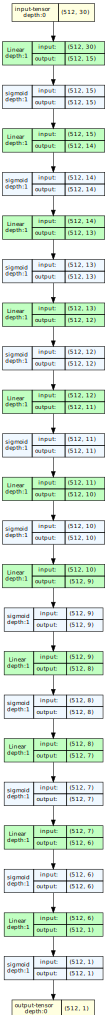

In [15]:
from torchview import draw_graph
import graphviz

graph = draw_graph(fc_network,
                   input_data=(x),
                   expand_nested=True)
graph.visual_graph

Существует много приемов и их сочетаний для починки затухания градиентов :



* смена функции активации на ReLU и ее модификации
- Batch Normalization на каждом слое
- Residual Connections см. ResNet
- Изменение LR
- Gradient Clipping -- ограничить значение градиентов снизу (а если столкнулись с взрывом градиентов -- сверху)


Попробуем tanh в качестве функции активации

In [16]:
class DeepFCNetTanh(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DeepFCNetTanh, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size - 1))
            hidden_size -= 1
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.tanh(layer(x))
        return F.sigmoid(self.output_layer(x))

In [17]:
fc_network = DeepFCNetTanh(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

for idx, batch in enumerate(train_batched):
  x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
  optimizer.zero_grad()
  y_pred = fc_network(x)
  loss = criterion(y_pred, y_true)
  loss.backward()
  optimizer.step()
  for name, param in fc_network.named_parameters():
      if (param.grad is not None) and name.find('weight') > -1:
        try:
          gradient_norm = np.linalg.norm(param.grad, ord = 2)
          print(f'Gradient of {name}: {gradient_norm}')
        except Exception as ex:
          print(ex)
          print(f'Gradient of {name}: {param.grad}')
      else:
          pass
  break

Gradient of layers.0.weight: 0.0011775048915296793
Gradient of layers.1.weight: 0.0008516611997038126
Gradient of layers.2.weight: 0.0008693158160895109
Gradient of layers.3.weight: 0.0006663861568085849
Gradient of layers.4.weight: 0.0015627836110070348
Gradient of layers.5.weight: 0.0018168744863942266
Gradient of layers.6.weight: 0.003126473631709814
Gradient of layers.7.weight: 0.014287062920629978
Gradient of layers.8.weight: 0.017811840400099754
Gradient of layers.9.weight: 0.04836058244109154
Gradient of output_layer.weight: 0.046433884650468826


В теории у tanh проблема такая же, но ситуация заметно лучше

попробуем ReLU

In [18]:
class DeepFCNetRelu(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DeepFCNetRelu, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size - 1))
            hidden_size -= 1
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.relu(layer(x))
        return F.sigmoid(self.output_layer(x))

In [19]:
fc_network = DeepFCNetRelu(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

for idx, batch in enumerate(train_batched):
  x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
  optimizer.zero_grad()
  y_pred = fc_network(x)
  loss = criterion(y_pred, y_true)
  loss.backward()
  optimizer.step()
  for name, param in fc_network.named_parameters():
      if (param.grad is not None) and name.find('weight') > -1:
        try:
          gradient_norm = np.linalg.norm(param.grad, ord = 2)
          print(f'Gradient of {name}: {gradient_norm}')
        except Exception as ex:
          print(ex)
          print(f'Gradient of {name}: {param.grad}')
      else:
          pass
  break

Gradient of layers.0.weight: 8.226201316574588e-05
Gradient of layers.1.weight: 8.471183537039906e-05
Gradient of layers.2.weight: 8.858943328959867e-05
Gradient of layers.3.weight: 0.0001228367764269933
Gradient of layers.4.weight: 0.00030521448934450746
Gradient of layers.5.weight: 0.00021387227752711624
Gradient of layers.6.weight: 0.0008934767101891339
Gradient of layers.7.weight: 0.0017239036969840527
Gradient of layers.8.weight: 0.0024509718641638756
Gradient of layers.9.weight: 0.0053261276334524155
Gradient of output_layer.weight: 0.0043805502355098724


Не помогло!

## Домашнее задание:

попробовать 4 указанных ниже приема для борьбы с затуханием градиента на этом же датасете с архитектурой как в классе DeepFCNet и сказать какой прием сработал лучше

*   LeakyReLU (для самых дотошных -- [Mish](https://krutikabapat.github.io/Swish-Vs-Mish-Latest-Activation-Functions/))
*   Batch Normalization на каждом слое
*   Gradient Clipping (снизу)
*   менять LR в процессе обучения


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import IterableDataset
from torch.utils.data.dataloader import DataLoader

from matplotlib import pyplot as plt

import math
torch.backends.cudnn.enabled = True
torch.manual_seed(45)
torch.cuda.manual_seed(45)
torch.use_deterministic_algorithms(mode=True)

from sklearn.datasets import make_classification
import numpy as np

n_features = 30
n_samples = 200_000
data = make_classification(n_samples = n_samples, n_features =n_features, random_state = 42, n_redundant = 10)
def train_test_split(data, test_size=0.33, seed=903):
  rng = np.random.default_rng(seed=seed)
  idx = rng.choice([True, False], size=data[0].shape[0], p=[1 - test_size, test_size])
  return (data[0][idx, :], data[1][idx]), (data[0][~idx, :], data[1][~idx])

train, test = train_test_split(data)
def make_batch(dataset, batch_size = 512):
  data_batched = []
  for k in range(0, dataset[0].shape[0] // batch_size + 1):
    idx_left, idx_right = k * batch_size, min((k + 1) * batch_size, dataset[0].shape[0])
    data_batched.append((dataset[0][idx_left:idx_right, :], dataset[1][idx_left:idx_right]))
  assert (len(data_batched) - 1) * batch_size + data_batched[-1][0].shape[0] == dataset[0].shape[0]
  return data_batched

train_batched = make_batch(train)
test_batched = make_batch(test)

class DeepFCNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DeepFCNet, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size - 1))
            hidden_size -= 1
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.sigmoid(layer(x))
        return F.sigmoid(self.output_layer(x))

class DeepFCNetLeakyReLU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DeepFCNetLeakyReLU, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size - 1))
            hidden_size -= 1
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x), negative_slope=0.01)
        return F.sigmoid(self.output_layer(x))

class DeepFCNetMish(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DeepFCNetMish, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size - 1))
            hidden_size -= 1
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        for layer in self.layers:
            x = F.mish(layer(x))
        return F.sigmoid(self.output_layer(x))

class DeepFCNetBatchNorm(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DeepFCNetBatchNorm, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        self.layers.append(nn.Linear(input_size, hidden_size))
        self.batch_norms.append(nn.BatchNorm1d(hidden_size))

        current_size = hidden_size
        for _ in range(num_layers - 1):
            next_size = current_size - 1
            self.layers.append(nn.Linear(current_size, next_size))
            self.batch_norms.append(nn.BatchNorm1d(next_size))
            current_size = next_size

        self.output_layer = nn.Linear(current_size, 1)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.batch_norms[i](x)
            x = F.sigmoid(x)
        return F.sigmoid(self.output_layer(x))

print("=== Testing Baseline ===")
fc_network = DeepFCNet(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

baseline_gradients = []
for idx, batch in enumerate(train_batched):
    x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
    optimizer.zero_grad()
    y_pred = fc_network(x)
    loss = criterion(y_pred, y_true)
    loss.backward()

    batch_gradients = []
    for name, param in fc_network.named_parameters():
        if (param.grad is not None) and name.find('weight') > -1:
            try:
                gradient_norm = torch.norm(param.grad, p=2).item()
                batch_gradients.append(gradient_norm)
                print(f'Gradient of {name}: {gradient_norm}')
            except Exception as ex:
                print(ex)
                print(f'Gradient of {name}: {param.grad}')

    if batch_gradients:
        baseline_gradients.append(np.mean(batch_gradients))

    optimizer.step()
    break

print("\n=== Testing LeakyReLU ===")
fc_network = DeepFCNetLeakyReLU(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

leaky_gradients = []
for idx, batch in enumerate(train_batched):
    x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
    optimizer.zero_grad()
    y_pred = fc_network(x)
    loss = criterion(y_pred, y_true)
    loss.backward()

    batch_gradients = []
    for name, param in fc_network.named_parameters():
        if (param.grad is not None) and name.find('weight') > -1:
            try:
                gradient_norm = torch.norm(param.grad, p=2).item()
                batch_gradients.append(gradient_norm)
                print(f'Gradient of {name}: {gradient_norm}')
            except Exception as ex:
                print(ex)
                print(f'Gradient of {name}: {param.grad}')

    if batch_gradients:
        leaky_gradients.append(np.mean(batch_gradients))

    optimizer.step()
    break

print("\n=== Testing Mish ===")
fc_network = DeepFCNetMish(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

mish_gradients = []
for idx, batch in enumerate(train_batched):
    x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
    optimizer.zero_grad()
    y_pred = fc_network(x)
    loss = criterion(y_pred, y_true)
    loss.backward()

    batch_gradients = []
    for name, param in fc_network.named_parameters():
        if (param.grad is not None) and name.find('weight') > -1:
            try:
                gradient_norm = torch.norm(param.grad, p=2).item()
                batch_gradients.append(gradient_norm)
                print(f'Gradient of {name}: {gradient_norm}')
            except Exception as ex:
                print(ex)
                print(f'Gradient of {name}: {param.grad}')

    if batch_gradients:
        mish_gradients.append(np.mean(batch_gradients))

    optimizer.step()
    break

print("\n=== Testing BatchNorm ===")
fc_network = DeepFCNetBatchNorm(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

bn_gradients = []
for idx, batch in enumerate(train_batched):
    x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
    optimizer.zero_grad()
    y_pred = fc_network(x)
    loss = criterion(y_pred, y_true)
    loss.backward()

    batch_gradients = []
    for name, param in fc_network.named_parameters():
        if (param.grad is not None) and name.find('weight') > -1:
            try:
                gradient_norm = torch.norm(param.grad, p=2).item()
                batch_gradients.append(gradient_norm)
                print(f'Gradient of {name}: {gradient_norm}')
            except Exception as ex:
                print(ex)
                print(f'Gradient of {name}: {param.grad}')

    if batch_gradients:
        bn_gradients.append(np.mean(batch_gradients))

    optimizer.step()
    break

print("\n=== Testing Gradient Clipping ===")
fc_network = DeepFCNet(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)

clip_gradients = []
for idx, batch in enumerate(train_batched):
    x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
    optimizer.zero_grad()
    y_pred = fc_network(x)
    loss = criterion(y_pred, y_true)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(fc_network.parameters(), max_norm=1.0)

    batch_gradients = []
    for name, param in fc_network.named_parameters():
        if (param.grad is not None) and name.find('weight') > -1:
            try:
                gradient_norm = torch.norm(param.grad, p=2).item()
                batch_gradients.append(gradient_norm)
                print(f'Gradient of {name}: {gradient_norm}')
            except Exception as ex:
                print(ex)
                print(f'Gradient of {name}: {param.grad}')

    if batch_gradients:
        clip_gradients.append(np.mean(batch_gradients))

    optimizer.step()
    break

print("\n=== Testing LR Scheduler ===")
fc_network = DeepFCNet(n_features, 15, 1, num_layers = 10)
criterion = nn.BCELoss()
optimizer = optim.SGD(fc_network.parameters(), lr = 0.1, momentum = 0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

lr_gradients = []
for idx, batch in enumerate(train_batched):
    x, y_true = torch.Tensor(batch[0]), torch.Tensor(batch[1].reshape(-1,1))
    optimizer.zero_grad()
    y_pred = fc_network(x)
    loss = criterion(y_pred, y_true)
    loss.backward()

    batch_gradients = []
    for name, param in fc_network.named_parameters():
        if (param.grad is not None) and name.find('weight') > -1:
            try:
                gradient_norm = torch.norm(param.grad, p=2).item()
                batch_gradients.append(gradient_norm)
                print(f'Gradient of {name}: {gradient_norm}')
            except Exception as ex:
                print(ex)
                print(f'Gradient of {name}: {param.grad}')

    if batch_gradients:
        lr_gradients.append(np.mean(batch_gradients))

    optimizer.step()
    scheduler.step()
    break

print("\n" + "="*50)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*50)

results = {
    "Baseline": np.mean(baseline_gradients) if baseline_gradients else 0,
    "LeakyReLU": np.mean(leaky_gradients) if leaky_gradients else 0,
    "Mish": np.mean(mish_gradients) if mish_gradients else 0,
    "BatchNorm": np.mean(bn_gradients) if bn_gradients else 0,
    "GradientClipping": np.mean(clip_gradients) if clip_gradients else 0,
    "LRScheduler": np.mean(lr_gradients) if lr_gradients else 0
}

for method, grad_norm in results.items():
    print(f"{method:20} | Норма градиента: {grad_norm:.6f}")

best_method = min(results, key=results.get)
print(f"\nЛучший метод: {best_method}")

=== Testing Baseline ===
Gradient of layers.0.weight: 2.8659230544292313e-09
Gradient of layers.1.weight: 8.669704953945256e-09
Gradient of layers.2.weight: 4.9095302045998324e-08
Gradient of layers.3.weight: 3.937931580821896e-07
Gradient of layers.4.weight: 2.6543682452029316e-06
Gradient of layers.5.weight: 2.0778268662979826e-05
Gradient of layers.6.weight: 0.00022842068574391305
Gradient of layers.7.weight: 0.0015244397800415754
Gradient of layers.8.weight: 0.007335189264267683
Gradient of layers.9.weight: 0.03968513756990433
Gradient of output_layer.weight: 0.24395239353179932

=== Testing LeakyReLU ===
Gradient of layers.0.weight: 1.5889032738414244e-06
Gradient of layers.1.weight: 1.1733364999599871e-06
Gradient of layers.2.weight: 1.3825676887790905e-06
Gradient of layers.3.weight: 2.7437902190285968e-06
Gradient of layers.4.weight: 1.3173320439818781e-05
Gradient of layers.5.weight: 3.442670276854187e-05
Gradient of layers.6.weight: 0.0003888725768774748
Gradient of layers.7.